In [2]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree
import cv2
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xml_path = "C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\annotations.xml"
annotations = ElementTree.parse(xml_path)
root = annotations.getroot()

In [4]:
# how to extract ids from annotations
ids = []
head_coordinates = []
label = []

for image in root:
    try:
        ids.append(image.attrib["id"])
        for objects in image:
            xtl = ytl = xbr = ybr = 0
            if (objects.attrib["label"] == "head"):
                xtl = objects.attrib["xtl"]
                xbr = objects.attrib["xbr"]
                ytl = objects.attrib["ytl"]
                ybr = objects.attrib["ybr"]
            head_coordinates.append([ytl, ybr, xtl, xbr])
            for conditions in objects:
                mask = safety_helmet = "no"
                if (conditions.attrib["name"] == "has_safety_helmet"): safety_helmet = conditions.text
                if (conditions.attrib["name"] == "mask"): mask = conditions.text
                label.append([safety_helmet, mask])
            
    except:
        print("yo")

yo
yo


In [116]:
len(label)

5248

In [15]:
for x in root[54]:
    if (x.attrib["label"] == "head"):
        print(x.attrib["xtl"])

396.80


In [17]:
for x in root[95]:
    print(x.attrib)

{'label': 'head', 'occluded': '0', 'xtl': '22.26', 'ytl': '0.00', 'xbr': '155.82', 'ybr': '120.84'}


In [15]:
root[95].attrib["id"]

'121'

In [11]:
root_ids = []
for x in root[2:]:
    root_ids.append(x.attrib['id'])
    
len(root_ids)

527

In [16]:
root_ids.index('121')

'0'

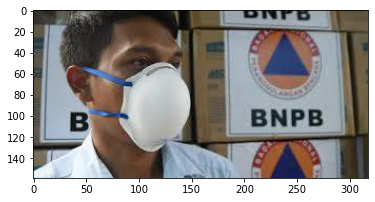

In [18]:
img = cv2.imread("C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\images\\121.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

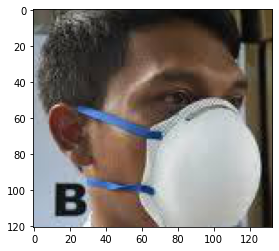

In [20]:
xtl = 23; ytl = 0; 
xbr = 156; ybr = 121;

head = img[ytl:ybr, xtl:xbr]
plt.imshow(head)

In [171]:
head = img_to_array(head)

In [175]:
width = 254
height = 254
dim = (width, height)

resized = cv2.resize(head, dim, interpolation = cv2.INTER_AREA)
#plt.imshow(resized)

# Preparing Dataset

In [ ]:
### importing libraries:


In [4]:
### uploading and reading of the provided .xml file

xml_path = "C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\annotations.xml"
annotations = ElementTree.parse(xml_path)
root = annotations.getroot()

In [49]:
### try our dim(16, 16) dim(8, 8)
### a process of preparing our dataset for training

data = []
label = []
dim = (224, 224)
dict_to_track_errors = {}; small_image=0; no_human_face=0;

for image in root[2:]:
    image_id = image.attrib["id"]
    path = "C:\\Users\\dias_\\Desktop\\Customindz\\task 2\\dataset\\images\\{}.jpg".format(image_id)
    img = load_img(path)
    img = img_to_array(img)
    try:
        for objects in image:
            
            ### finding out the face box for each person in the image:
            if (objects.attrib["label"] == "head"):
                xtl = int(float(objects.attrib["xtl"]))
                ytl = int(float(objects.attrib["ytl"]))
                xbr = int(float(objects.attrib["xbr"]))
                ybr = int(float(objects.attrib["ybr"]))
                
                ### cropping out the face:
                head_img = img[ytl:ybr, xtl:xbr]
                
                ### a filter to remove very small images which will be negatively effecting the model:
                if head_img.shape[0] > 32 and head_img.shape[1] > 32:
                    
                    ### resizing all images to standartize their resolution for model:
                    resized = cv2.resize(head_img, dim, interpolation = cv2.INTER_AREA)
                    #preprocessed = preprocess_input(resized)
                    data.append(resized)
                    for conditions in objects:
                        if (conditions.attrib["name"] == "has_safety_helmet"): safety_helmet = conditions.text
                        if (conditions.attrib["name"] == "mask"): mask = conditions.text
                    mark = [1 if (safety_helmet == 'yes' and mask == 'yes') else 0]
                    label.append(mark[0])
                else: 
                    small_image += 1
                
            else:
                no_human_face += 1

    except Exception as err:
        print(err)

dict_to_track_errors["too small_image count"] = small_image
dict_to_track_errors["no face images count"] = no_human_face


In [50]:
### from below results we could observe that 1338 face images were excluded from training dataset due to resolution
### the final dataset of 454 images in considered low for model traning, therefore, we should try out different variations of 
### image resolution, and come up with the best approach:

print(len(data))
print(len(label))
dict_to_track_errors

454
454


{'too small_image count': 1338, 'no face images count': 2674}

In [51]:
### we see that "other cases" are twice more than cases with mask and safety helmet wearing people.
### therefore, we will probably need "stratify" argument in splitting the data

print("There are ", sum(label), " cases with mask and safety helmet")
print("There are ", 454 - sum(label), " other cases")

There are  146  cases with mask and safety helmet
There are  308  other cases


In [52]:
### converting them into numpy arrays for training:

datas = np.array(data, dtype="float32")
labels = np.array(label)

In [53]:
### split into train test sets:

(trainX, testX, trainY, testY) = train_test_split(datas, labels, test_size=0.30, stratify=labels, random_state=42)

In [ ]:
### As our image resolutions are small and dataset is also small, we will probably try out a simple model for training.

### 

### MaxPooling2D was used for this model because mask and helmets are usually bright in color while the backgrounds are darker.
### Therefore, I believe in our case MaxPooling will work out good. 

In [54]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [55]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [56]:
### 32x32 resolution filter, 32x32res input image

BS = 32
EPOCHS = 20

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
9/9 [==============================] - 11s 1s/step - loss: 119.2392 - accuracy: 0.5649 - val_loss: 3.5577 - val_accuracy: 0.3212
Epoch 2/20
9/9 [==============================] - 11s 1s/step - loss: 1.9046 - accuracy: 0.5754 - val_loss: 1.5203 - val_accuracy: 0.3431
Epoch 3/20
9/9 [==============================] - 11s 1s/step - loss: 1.0277 - accuracy: 0.5404 - val_loss: 0.6472 - val_accuracy: 0.6058
Epoch 4/20
9/9 [==============================] - 11s 1s/step - loss: 0.6696 - accuracy: 0.6458 - val_loss: 0.6156 - val_accuracy: 0.6861
Epoch 5/20
9/9 [==============================] - 11s 1s/step - loss: 0.6436 - accuracy: 0.6386 - val_loss: 0.6245 - val_accuracy: 0.6350
Epoch 6/20
9/9 [==============================] - 13s 1s/step - loss: 0.6287 - accuracy: 0.6737 - val_loss: 0.6164 - val_accuracy: 0.6569
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.6520 - accuracy: 0.6702 - val_loss: 0.6160 - val_accuracy: 0.6642
Epoch 8/20
9/9 [================

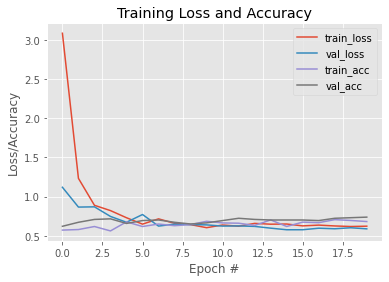

In [48]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [277]:
print(len(data))
print(len(label))
#print(sum(label))

1792
1792


In [278]:
datas = np.array(data, dtype="float32")
labels = np.array(label)

In [279]:
(trainX, testX, trainY, testY) = train_test_split(datas, labels, test_size=0.30, stratify=labels, random_state=42)

In [244]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [225]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 5s 0us/step


In [247]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [235]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(224, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [237]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [238]:
for layer in baseModel.layers:
    layer.trainable = False

In [240]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [245]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
4/4 [==============================] - 4s 1s/step - loss: 2.7323 - accuracy: 0.4300 - val_loss: 1.0240 - val_accuracy: 0.4848
Epoch 2/20
4/4 [==============================] - 4s 911ms/step - loss: 1.4494 - accuracy: 0.4300 - val_loss: 0.8437 - val_accuracy: 0.4848
Epoch 3/20
4/4 [==============================] - 4s 898ms/step - loss: 1.1283 - accuracy: 0.5400 - val_loss: 0.7461 - val_accuracy: 0.3636
Epoch 4/20
4/4 [==============================] - 4s 931ms/step - loss: 0.8991 - accuracy: 0.4500 - val_loss: 0.7122 - val_accuracy: 0.3333
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.7539 - accuracy: 0.4219 - val_loss: 0.7632 - val_accuracy: 0.6667
Epoch 6/20
4/4 [==============================] - 3s 856ms/step - loss: 0.7351 - accuracy: 0.5900 - val_loss: 0.7095 - val_accuracy: 0.6667
Epoch 7/20
4/4 [==============================] - 3s 866ms/step - loss: 0.7120 - accuracy: 0.5000 - val_loss: 0.6956

In [246]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


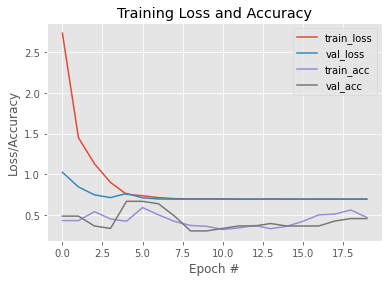

In [256]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [261]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense

In [280]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [281]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
44/44 [==============================] - 60s 1s/step - loss: 0.5728 - accuracy: 0.7944 - val_loss: 0.5183 - val_accuracy: 0.7939
Epoch 2/20
44/44 [==============================] - 71s 2s/step - loss: 0.5027 - accuracy: 0.7959 - val_loss: 0.5088 - val_accuracy: 0.7855
Epoch 3/20
44/44 [==============================] - 70s 2s/step - loss: 0.4995 - accuracy: 0.7944 - val_loss: 0.4950 - val_accuracy: 0.7911
Epoch 4/20
44/44 [==============================] - 68s 2s/step - loss: 0.4870 - accuracy: 0.7959 - val_loss: 0.4705 - val_accuracy: 0.7883
Epoch 5/20
44/44 [==============================] - 69s 2s/step - loss: 0.4892 - accuracy: 0.8030 - val_loss: 0.4754 - val_accuracy: 0.7883
Epoch 6/20
44/44 [==============================] - 70s 2s/step - loss: 0.4766 - accuracy: 0.7894 - val_loss: 0.4709 - val_accuracy: 0.7939
Epoch 7/20
44/44 [==============================] - 71s 2s/step - loss: 0.4785 - accuracy: 0.7966 - val_loss: 0.4745 - val_accuracy: 0.7911
Epoch 8/20
44/44 [==

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

NameError: name 'EPOCHS' is not defined

In [ ]:
pillow library